## Imports

In [99]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import memory_profiler
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential

In [35]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Нормалізація даних
# x_train = tf.keras.utils.normalize(x_train, axis=1)
# x_test = tf.keras.utils.normalize(x_test, axis=1)

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape
x_train_flat = x_train.reshape((len(x_train), 784))
x_test_flat = x_test.reshape((len(x_test), 784))


In [7]:
x_train_flat.shape

(60000, 784)

## Pipeline

In [87]:
# SVD
svd = TruncatedSVD(n_components=625)

def svd_fit():
    svd.fit(x_train_flat)

start_time = time.time()
svd_fit()
svd_train_time = time.time() - start_time

x_train_flat_cut = svd.transform(x_train_flat)
x_train_flat_cut.shape

(60000, 625)

In [88]:
# AE
latent_dim = 64
inputs = Input(shape=(784,))
encoded = Dense(128, activation='relu')(inputs)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(625, activation='sigmoid')(decoded)
# outputs = Reshape((28, 28))(decoded)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

def ae_fit():
    autoencoder.fit(x_train_flat, x_train_flat_cut, epochs=10)

start_time = time.time()
ae_fit()
AE_train_time = time.time() - start_time

x_train_flat_cut = autoencoder.predict(x_train_flat)
print(x_train_flat_cut.shape)
x_test_flat_cut = autoencoder.predict(x_test_flat)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1188
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1058
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1026
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1016
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1009
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1005
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1004
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1001
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0999
Epoch 10/10
1875/1875 [==============================] - 2s 886us/step
(60000, 625)
313/313 [==============================] - 0s 920us/step


In [89]:
# SVD
svd = TruncatedSVD(n_components=484)

def svd_fit():
    svd.fit(x_train_flat_cut)

start_time = time.time()
svd_fit()
svd_train_time = time.time() - start_time

x_train_transformed = svd.transform(x_train_flat_cut)
print(x_train_transformed.shape)
x_test_transformed = svd.transform(x_test_flat_cut)

(60000, 484)


In [90]:
x_train_reduced = np.reshape(x_train_transformed, (len(x_train_transformed), 22, 22))
x_test_reduced = np.reshape(x_test_transformed, (len(x_test_transformed), 22, 22))
x_train_reduced.shape

(60000, 22, 22)

## evaluation on model LeNet-5

In [91]:
# Перетворюємо цілочисельні мітки на одне-гаряче кодування
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=10)

### build and train model on original data

In [108]:
# Додаємо канал кольору
x_train_mod = tf.expand_dims(x_train, axis=-1)
x_test_mod = tf.expand_dims(x_test, axis=-1)

model = Sequential()

# Перший згортковий блок
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Другий згортковий блок
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Повнозв'язні шари
model.add(Flatten())
model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(10, activation='softmax'))

# Компіляція моделі
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_mod, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test_mod, y_test_cat))

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2322 - accuracy: 0.9295 - val_loss: 0.1119 - val_accuracy: 0.9642
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0942 - accuracy: 0.9718 - val_loss: 0.0807 - val_accuracy: 0.9745
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0643 - accuracy: 0.9804 - val_loss: 0.0615 - val_accuracy: 0.9819
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0473 - accuracy: 0.9853 - val_loss: 0.0584 - val_accuracy: 0.9827
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0375 - accuracy: 0.9886 - val_loss: 0.0480 - val_accuracy: 0.9848
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0309 - accuracy: 0.9898 - val_loss: 0.0682 - val_accuracy: 0.9793
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0508 - val_accuracy:

### build and train model on reduced data

In [109]:
# Додаємо канал кольору
x_train_reduced_mod = tf.expand_dims(x_train_reduced, axis=-1)
x_test_reduced_mod = tf.expand_dims(x_test_reduced, axis=-1)

model2 = Sequential()

# Перший згортковий блок
model2.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(22,22,1), padding='same'))
model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Другий згортковий блок
model2.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Повнозв'язні шари
model2.add(Flatten())
model2.add(Dense(120, activation='tanh'))
model2.add(Dense(84, activation='tanh'))
model2.add(Dense(10, activation='softmax'))

# Компіляція моделі
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(x_train_reduced_mod, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test_reduced_mod, y_test_cat))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1408 - accuracy: 0.6235 - val_loss: 0.8142 - val_accuracy: 0.7478
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7416 - accuracy: 0.7689 - val_loss: 0.6915 - val_accuracy: 0.7849
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6531 - accuracy: 0.7976 - val_loss: 0.6142 - val_accuracy: 0.8146
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5956 - accuracy: 0.8158 - val_loss: 0.5673 - val_accuracy: 0.8273
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5398 - accuracy: 0.8319 - val_loss: 0.5091 - val_accuracy: 0.8473
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4898 - accuracy: 0.8478 - val_loss: 0.4769 - val_accuracy: 0.8560
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4509 - accuracy: 0.8584 - val_loss: 0.4474 - val_accuracy:

### Performance evaluation

313/313 [==============================] - 0s 2ms/step - loss: 0.3869 - accuracy: 0.8793
Оцінка моделей оригінальні\редуковані дані 0.5864644050598145\0.5226666927337646 секунд
Точність: 0.9851999878883362\0.8792999982833862
Втрати: 0.051351409405469894\0.3869428038597107
313/313 [==============================] - 0s 1ms/step
Класифікаційний звіт для оригінальних даних:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                   

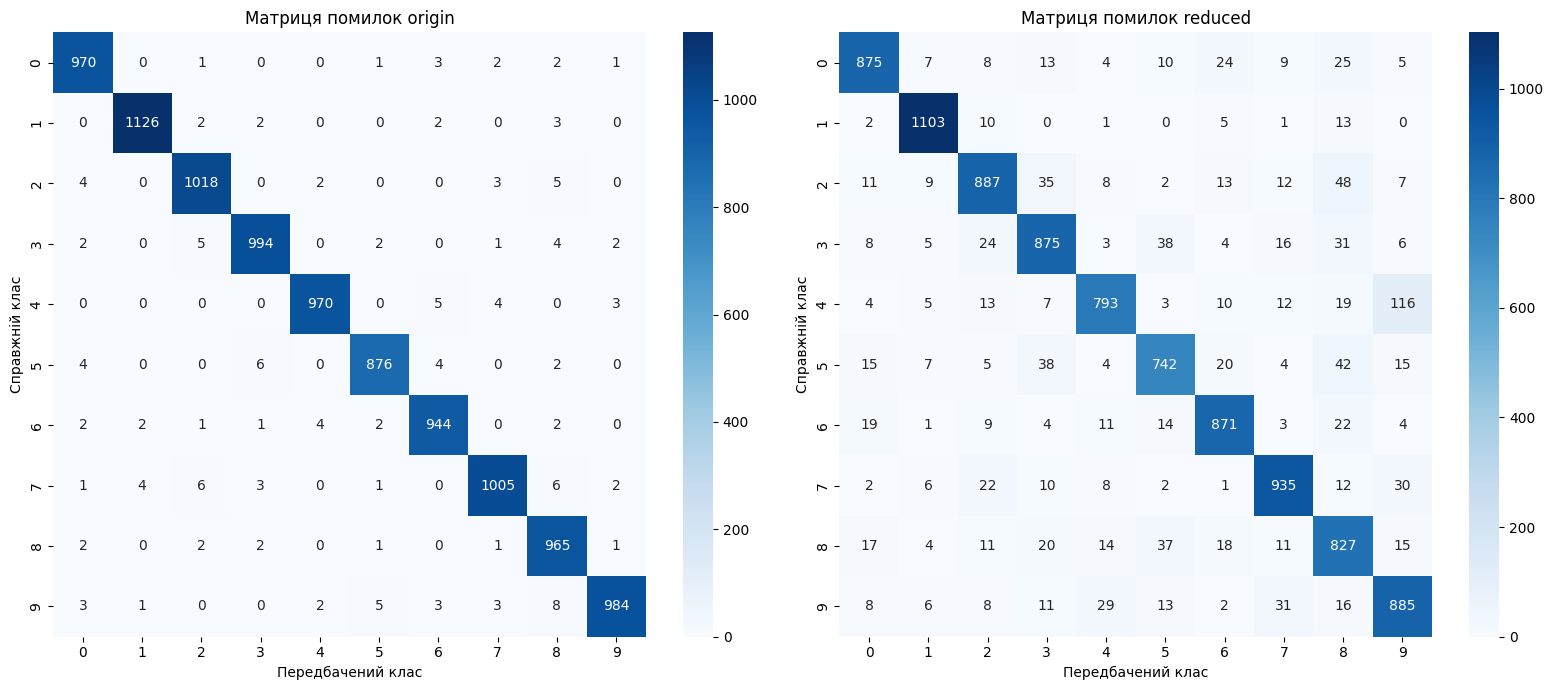

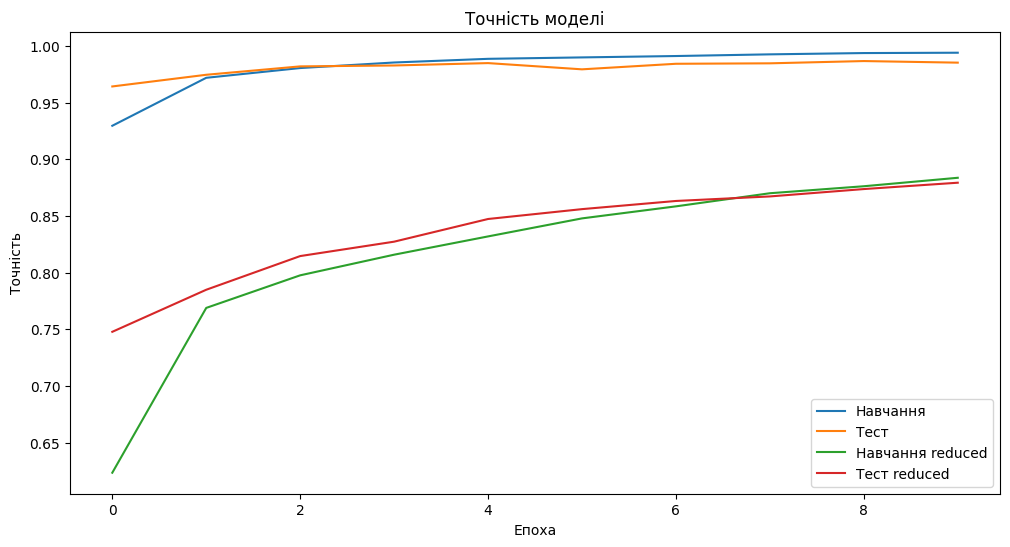

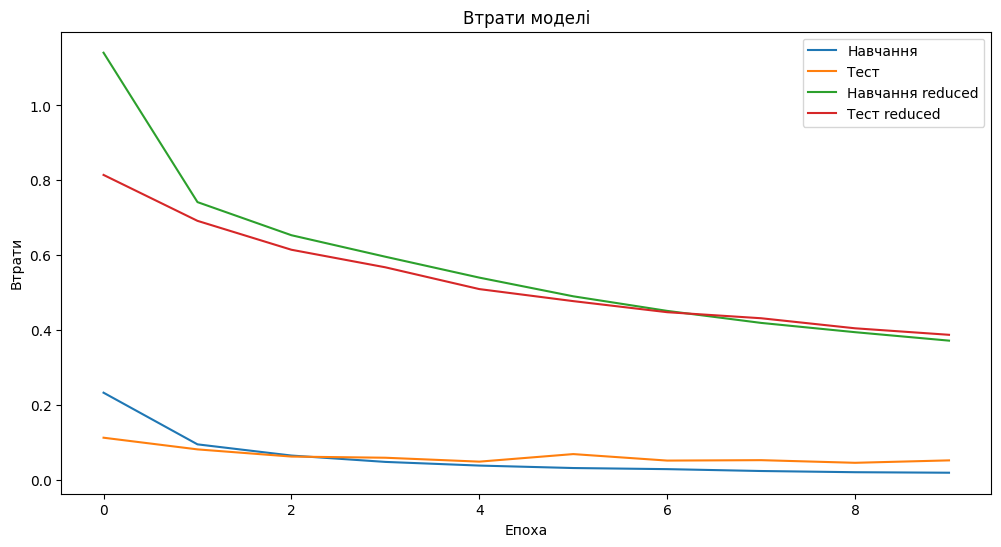

In [112]:
# Оцінка моделі
start_time = time.time()
loss, accuracy = model.evaluate(x_test_mod, y_test_cat)
time1 = time.time() - start_time

start_time = time.time()
loss2, accuracy2 = model2.evaluate(x_test_reduced_mod, y_test_cat)
time2 = time.time() - start_time

print(f"Оцінка моделей оригінальні\редуковані дані {time1}\{time2} секунд")
print(f"Точність: {accuracy}\{accuracy2}")
print(f"Втрати: {loss}\{loss2}")

# Передбачення моделі
y_pred = model.predict(x_test_mod)
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred2 = model2.predict(x_test_reduced_mod)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Виведення декількох метрик
print("Класифікаційний звіт для оригінальних даних:")
print(classification_report(y_test, y_pred_classes))
print("Класифікаційний звіт для редукованих даних:")
print(classification_report(y_test, y_pred_classes2))

# confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm2 = confusion_matrix(y_test, y_pred_classes2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Матриця помилок origin')
ax1.set_xlabel('Передбачений клас')
ax1.set_ylabel('Справжній клас')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Матриця помилок reduced')
ax2.set_xlabel('Передбачений клас')
ax2.set_ylabel('Справжній клас')
plt.tight_layout()
plt.show()

# Побудова графіка точності
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Точність моделі')
plt.ylabel('Точність')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Тест', 'Навчання reduced', 'Тест reduced'], loc='best')
plt.show()

# Побудова графіка втрат
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Втрати моделі')
plt.ylabel('Втрати')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Тест', 'Навчання reduced', 'Тест reduced'], loc='upper right')
plt.show()

313/313 [==============================] - 0s 2ms/step - loss: 0.0574 - accuracy: 0.9849
Оцінка моделі зайняла 0.5362343788146973 секунд
Точність: 0.9848999977111816
Втрати: 0.05741198733448982
313/313 [==============================] - 0s 1ms/step
Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.99       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       1.00      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.99  

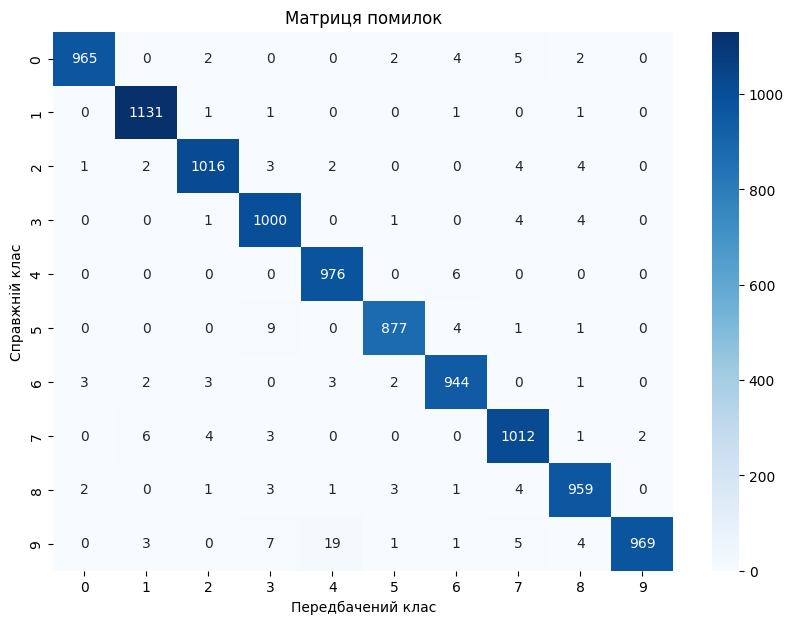

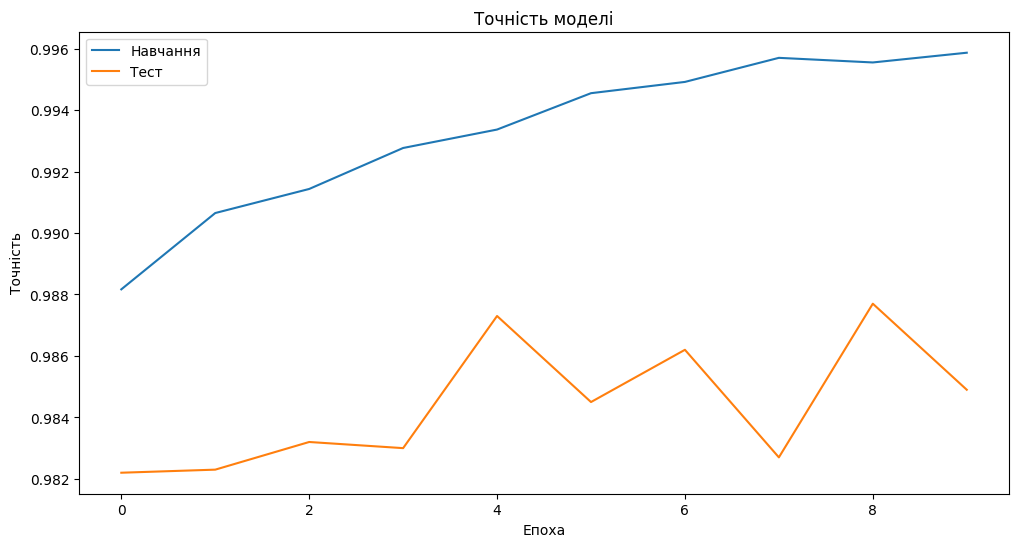

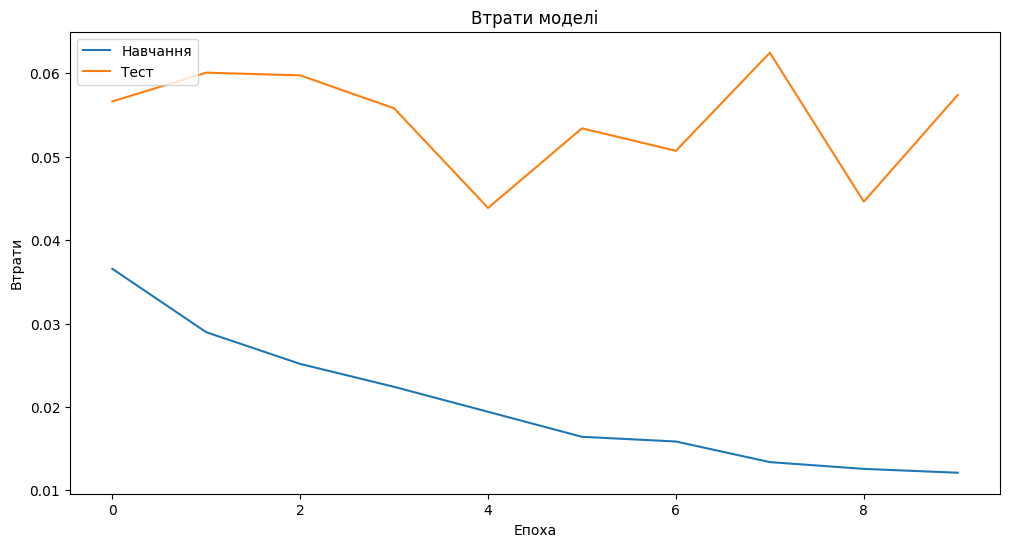

In [77]:
# score(model, history, x_test_mod, y_test, y_test_cat)

In [113]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

# mse = mean_squared_error(x_train_flat, x_train_svd)
# print(f"MSE train: {mse:.4f}")
# print("AE memory usage:", memory_profiler.memory_usage(ae_fit))
# print("AE memory usage:", memory_profiler.memory_usage(svd_fit))

AE train time: 30.982637405395508
SVD train time: 4.309696197509766
